<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: старший преподаватель Факультета Компьютерных Наук НИУ ВШЭ Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Занятие 8. Продвинутые методы классификации и регрессии. Xgboost</center>
## <center>Практика. Настройка Xgboost в задаче классификации. Решение</center>

In [1]:
import numpy as np
import pandas as pd
%pylab inline
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold

Populating the interactive namespace from numpy and matplotlib


**Считаем данные по оттоку клиентов телеком-оператора.**

In [2]:
df = pd.read_csv('../../data/telecom_churn.csv')

In [3]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


**Сделаем минмимальную предобработку.**

In [4]:
df['International plan'] = pd.factorize(df['International plan'])[0]

In [5]:
df['Churn'] = df['Churn'].astype('int')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
State                     3333 non-null object
Account length            3333 non-null int64
Area code                 3333 non-null int64
International plan        3333 non-null int64
Voice mail plan           3333 non-null object
Number vmail messages     3333 non-null int64
Total day minutes         3333 non-null float64
Total day calls           3333 non-null int64
Total day charge          3333 non-null float64
Total eve minutes         3333 non-null float64
Total eve calls           3333 non-null int64
Total eve charge          3333 non-null float64
Total night minutes       3333 non-null float64
Total night calls         3333 non-null int64
Total night charge        3333 non-null float64
Total intl minutes        3333 non-null float64
Total intl calls          3333 non-null int64
Total intl charge         3333 non-null float64
Customer service calls    3333 non-null int64
C

In [7]:
df.drop(['State', 'Voice mail plan'], axis=1, inplace=True)

**Оставим 30% данных на финальную проверку моделей.**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Churn', axis=1), df['Churn'],
                                                    test_size=0.3, random_state=7)

**Зафиксируем объект StratifiedKFold, с его помощью будет проводить кросс-валидацию.**

In [9]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

**Используйте sklearn-обертку Xgboost для оценки ROC AUC на кросс-валидации с данными (X_train, y_train). Пока оставьте параметры XGBClassifier по умолчанию (только seed=7, это то же по сути, что random_state). Выведите средний ROC AUC на кросс-вадидации, используйте ранее созданный объект StratifiedKFold.**

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

In [11]:
xgb_model1 = XGBClassifier(seed=7)

In [12]:
%%time
np.mean(cross_val_score(xgb_model1, X_train, y_train, cv=skf,
                       scoring='roc_auc'))

CPU times: user 1.47 s, sys: 561 ms, total: 2.03 s
Wall time: 1.27 s


0.90480673316708216

**Обучите модель на (X_train, y_train) и выведите оценку важности признаков (plot_importance из xgboost).**

In [13]:
from xgboost import plot_importance

In [14]:
xgb_model1.fit(X_train, y_train);

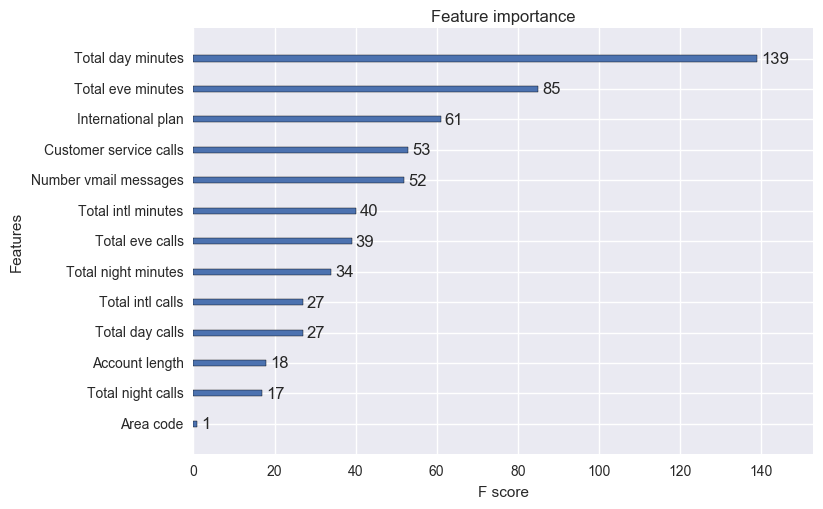

In [15]:
plot_importance(xgb_model1);

**Постройте кривые валидации по глубине деревьев от 2 до 7. Все прочие параметры кросс-валидации возьмите как на предыдущем шаге. Достаточно сохранять только средний AUC на валидационной части (на обучающей – не надо).**

In [16]:
%%time
tree_depths = np.arange(2,8)
xgb_scores = []
for depth in tree_depths:
    print(depth, end=' ')
    xgb_model = XGBClassifier(max_depth=depth, seed=7)
    xgb_cv_score = np.mean(cross_val_score(xgb_model, X_train, y_train, cv=skf,
                                              scoring='roc_auc'))
    xgb_scores.append(xgb_cv_score)

2 3 4 5 6 7 CPU times: user 12.1 s, sys: 4.66 s, total: 16.8 s
Wall time: 9.47 s


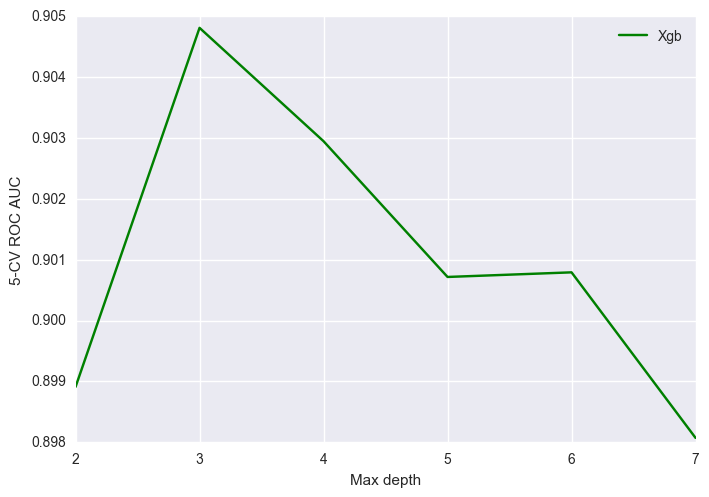

In [17]:
plot(tree_depths, xgb_scores, color='green', label='Xgb');
xlabel('Max depth')
ylabel('5-CV ROC AUC')
legend();

**Используйте RandomizedGridSearch, чтобы настроить параметры бустинга. Задайте 10 итераций (будут перебираться случайные 10 комбинаций параметров), а кросс-валидацию – как ранее. Выведите лучшие параметры и ROC AUC (поля best\_params\_ и best\_score\_ у обученного RandomizedGridSearch).**

In [18]:
from sklearn.model_selection import RandomizedSearchCV

In [19]:
xgb_params_dist_grid = {
    'max_depth': [2, 4, 6],
    'gamma': np.linspace(0, 0.5, 5),
    'subsample': [0.5, 0.75, 1.],
    'colsample_bytree': [0.5, 0.75, 1.]
}
xgb_params_fixed = {
    'objective': 'binary:logistic',
    'silent': 1,
    'seed': 7
}

In [20]:
xgb_grid = RandomizedSearchCV(
    estimator=XGBClassifier(**xgb_params_fixed),
    param_distributions=xgb_params_dist_grid,
    n_iter=10,
    cv=skf,
    scoring='roc_auc',
    random_state=7,
)

In [21]:
%%time
xgb_grid.fit(X_train, y_train);

CPU times: user 14.6 s, sys: 6.77 s, total: 21.4 s
Wall time: 12.1 s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True),
          error_score='raise',
          estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=7, silent=1, subsample=1),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'subsample': [0.5, 0.75, 1.0], 'max_depth': [2, 4, 6], 'gamma': array([ 0.   ,  0.125,  0.25 ,  0.375,  0.5  ]), 'colsample_bytree': [0.5, 0.75, 1.0]},
          pre_dispatch='2*n_jobs', random_state=7, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

In [22]:
xgb_grid.best_params_

{'colsample_bytree': 0.75, 'gamma': 0.25, 'max_depth': 4, 'subsample': 1.0}

In [23]:
xgb_grid.best_score_

0.90890117079264077

**Теперь построим кривые валидации Xgboost с помощью функции cv из xgboost. Теперь построим кривые валидации Xgboost с помощью функции cv из xgboost. Важный момент: в общем случае лучшие параметры для XGBCLassifier могут не быть таковыми для оригинальной питоновской обертки Xgboost, это надо проверять. Либо пользоваться не оберткой sklearn, а, например hyperopt для настройки параметров.**

In [24]:
from xgboost import cv, DMatrix

In [25]:
dtrain = DMatrix(X_train, y_train)

In [41]:
best_xgb_params = {'colsample_bytree': 0.75, 'gamma': 0.25, 
                   'max_depth': 4, 'subsample': 1,
                   'objective': 'binary:logistic',
                   'eval_metric': 'auc',
                    'silent': 1, 'seed': 7}

In [42]:
cv_result = cv(best_xgb_params, dtrain, num_boost_round=100, seed=7)

In [43]:
cv_result.head()

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.860304,0.029076,0.878589,0.009941
1,0.869101,0.029542,0.898280,0.005644
2,0.882958,0.031317,0.909453,0.009913
3,0.889783,0.033067,0.917488,0.006716
4,0.895847,0.030273,0.925638,0.006134


In [29]:
def plot_with_err(index, means, stds=None, **kwargs):
    lines = plt.plot(index, means, '-', **kwargs)
    plt.fill_between(index, means - stds, means + stds, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

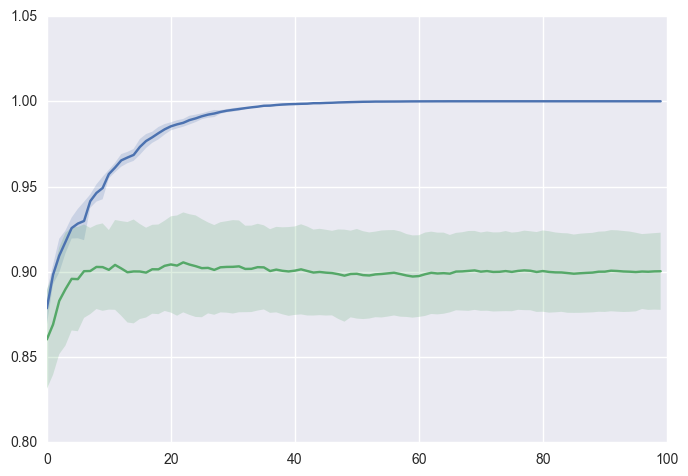

In [44]:
plot_with_err(cv_result.index, cv_result['train-auc-mean'], cv_result['train-auc-std']);
plot_with_err(cv_result.index, cv_result['test-auc-mean'], cv_result['test-auc-std']);

**Как правило, бустинг лучще работает, если шаг градиентного спуска мал, а число итераций велико. Проще говоря, так он аккуратно находит минимум оптимизируемой функции.**

In [45]:
best_xgb_params['eta'] = 0.003

In [46]:
cv_result2 = cv(best_xgb_params, dtrain, num_boost_round=3000, seed=7)

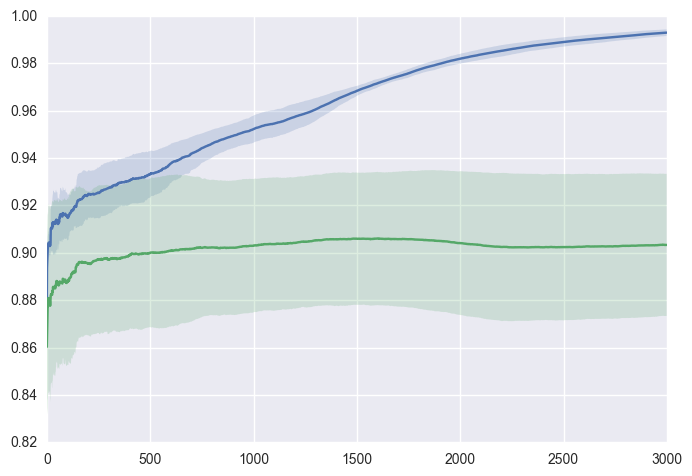

In [47]:
plot_with_err(cv_result2.index, cv_result2['train-auc-mean'], cv_result2['train-auc-std']);
plot_with_err(cv_result2.index, cv_result2['test-auc-mean'], cv_result2['test-auc-std']);

**Проверьте ROC AUC бустинга на оставленной выборке. Сравните начальную версию (без настройки параметров), промежуточную (с настроенными colsample_bytree, gamma, max_depth и subsample) и финальную (с настроенным вдобавок шагом и числом итераций).**

In [39]:
roc_auc_score(y_test, xgb_model1.predict_proba(X_test)[:,1])

0.92842095515892298

In [40]:
roc_auc_score(y_test, xgb_grid.predict_proba(X_test)[:,1])

0.93142270682377637

In [36]:
from xgboost import train

In [50]:
final_xgb = train(best_xgb_params, dtrain, num_boost_round=1500)

In [51]:
roc_auc_score(y_test, final_xgb.predict(DMatrix(X_test)))

0.93284255851100784